# Bitcoin Historical Price Data Feature Engineering

__Niklas Gutheil__<br>
__2022-03-01__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import datetime
import plotly.express as px
import requests
import json



## Table of Contents

* [Introduction](#introduction)<br>
* [Load in Data](#load)<br>
* [On-balance Volume](#obv)<br>
* [Exponential Moving Averages](#ema)<br>
* [Relative Strength Index](#rsi)<br>
* [Fear and Greed Index](#fear_greed)<br>
    - [Download Data](#download_greed)<br>
* [Puell Multiple](#puell)<br>
* [Stock-to-Flow Model](#s2f)<br>
* [Adding Features to Original Data](#adding)<br>
* [Trimming Data](#trimming)<br>
* [Data Dictionary](#dict)<br>
* [Saving Data](#saving)<br>

## Introduction <a class="anchor" id="introduction" ></a>

Currently there are only 5 features and 1 target variable for implementing future models. Those features are:
- __Date__: Time in Seconds since the Unix Epoch
- __Close__: The price of Bitcoin in USD at the end of a 5-minute interval
- __High__: The highest price of Bitcoin in USD during a 5-minute interval
- __Low__: The lowest price of Bitcoin in USD during a 5-minute interval
- __Volume__: The amount of Bitcoin bought and sold in a 5-minute interval

The target variable is: 

- __Open__: The price of Bitcoin in USD at the beginning of a 5-minute interval

I want to add features that will be predictive of the target variable `Open`. Luckily, Bitcoin and financial markets as a whole have many proven or popular indicators to predict if the price of an asset will rise or fall. I will explain each feature, and then add them to the dataset.

__Features to be added:__ <br>
- On-balance-volume (OBV)
- Exponential Moving Averages (EMAs) 7-day, 14-day, 21-day, 28-day, 5--day, 100-day and 150-day 
- Relative Strength Index (RSI)
- Fear and Greed Index 
- Puell Multiple (-could be important-)
- Stock to flow model (S2F Ratio = circ supply / yearly minting)

## Load in Data <a class = "anchor" id = "load"></a>

Let's load in the data and take a look at the current features. Then I can begin to explain and add new features.

In [2]:
bitcoin_df = pd.read_csv('./data/BTCUSD_5m historical data.csv')
bitcoin_df.rename(columns = {'Unnamed: 0': 'Date'}, inplace = True)
bitcoin_df.head()

,Date,Open,Close,High,Low,Volume
0,2013-04-15 04:00:00,93.6080,93.5030,93.608,93.503,49.168679
1,2013-04-15 04:05:00,93.5050,93.4970,93.612,93.380,172.309017
2,2013-04-15 04:10:00,93.7425,93.7385,93.796,93.680,86.527408
3,2013-04-15 04:15:00,93.9800,93.9800,93.980,93.980,0.745799
4,2013-04-15 04:20:00,94.1590,94.1590,94.159,94.159,0.759350


In [3]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916717 entries, 0 to 916716
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Date    916717 non-null  object 
 1   Open    916717 non-null  float64
 2   Close   916717 non-null  float64
 3   High    916717 non-null  float64
 4   Low     916717 non-null  float64
 5   Volume  916717 non-null  float64
dtypes: float64(5), object(1)
memory usage: 42.0+ MB


When reading in the dataframe, it reads the `Date` column in as an object, but it should be set to the datetime dtype.

In [4]:
bitcoin_df['Date'] = pd.to_datetime(bitcoin_df['Date'])
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916717 entries, 0 to 916716
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    916717 non-null  datetime64[ns]
 1   Open    916717 non-null  float64       
 2   Close   916717 non-null  float64       
 3   High    916717 non-null  float64       
 4   Low     916717 non-null  float64       
 5   Volume  916717 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 42.0 MB


__Important to note__ is that here I have to specifiy what time interval the dataset I am feeding in has. This is important for calculations and imputing other API data later on. I will also specify what currency pair this is to make sure I save the file with the correct name at the end.

In [5]:
time_interval = '5T'
pair = 'BTCUSD'

## On-balance-volume (OBV) <a class = "achor" id = "obv"></a>
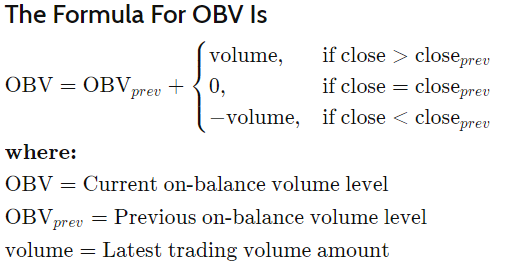

* On-balance volume (OBV) is a technical indicator of momentum, using volume changes to make price predictions.<br>
* OBV shows crowd sentiment that can predict a bullish or bearish outcome.

Here I'm going to modify a function that calculates OBV.

***************************************************************************************
*    Title: Pandas-Technical-Indicators
*    Author: egor-bogomolov
*    Date: March 28, 2018
*    Code version: 1.0
*    Availability: https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py
***************************************************************************************

In [6]:
def on_balance_volume(df, n=1):
    """Calculate On-Balance Volume for given data.
    
    df: dataframe containing the Close and Volume columns of the price chart
    n: the amount of days to average over, the standard is usually 1, so we set it to 1 as default 
    return: dataframe containing the OBV numbers
    """
    i = 0
    OBV = [0]
    while i < df.index[-1]:
        
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] > 0:
            OBV.append(df.loc[i + 1, 'Volume'])
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] == 0:
            OBV.append(0)
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] < 0:
            OBV.append(-df.loc[i + 1, 'Volume'])
        i = i + 1
        
        
    OBV = pd.DataFrame(OBV)
    OBV_ma = pd.DataFrame(OBV.rolling(n, min_periods=n).mean())
    
    return OBV_ma

In [7]:
# this cell will take a few minutes to run, no output is provided as printing a new line and clearing it
# makes the code run about 50x slower, not clearing the output makes it run faster, but having a list of 
# over 900,000 numbers creates RAM issues inside of internet browsers. 
obv_df = pd.concat([bitcoin_df['Close'], bitcoin_df['Volume']], axis = 1)


bitcoin_features_df = pd.DataFrame()

bitcoin_features_df['OBV'] = on_balance_volume(obv_df, 1)
bitcoin_features_df.head()

,OBV
0,0.000000
1,-172.309017
2,86.527408
3,0.745799
4,0.759350


I have now stored our OBV value in a dataframe where I will store all of the newly created features until I'm are ready to add them to the original dataset.

## Exponential Moving Averages <a class = "achor" id = "ema"></a>

My next features is moving average. I will be calculating the exponential moving average (EMA) rather than the simple moving average (SMA) as EMA weights recent prices higher, making it more responsive to new information. <br>

* A simple moving average (SMA) is a calculation that takes the arithmetic mean of a given set of prices over the specific number of days in the past; for example, over the previous 15, 30, 100, or 200 days.
* Exponential moving averages (EMA) is a weighted average that gives greater importance to the price of a stock in more recent days, making it an indicator that is more responsive to new information.

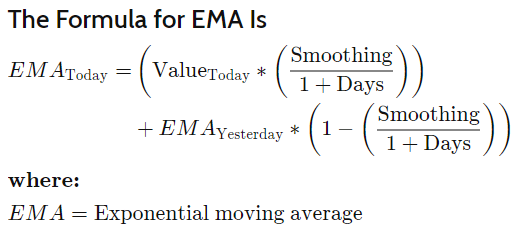

I will start by defining a function that will calculate EMA for any given time period `n`.

In [8]:
def EMA(df, n_range):
    """
    Calculates a range of EMA's defined by the list n_range
    
    Parameters: 
    
    df: pandas.DataFrame cointaining the Close prices
    n_range : list of moving average intervals to aggregate over
    
    Returns : EMA dataframe for all time intervals in n_range
    """
    EMA = pd.DataFrame()
    for n in n_range:
        name = 'EMA_' + str(n)
        EMA[n] = pd.DataFrame(df.ewm(span=n, min_periods=n).mean())
        EMA.rename(columns = {n: name}, inplace = True)
    
    return EMA

I want to create a few EMA's and add them to our feature dataframe. I want to chose some short time frames to gain an understanding of price action for days or weeks, but also include longer EMA's as they cancel out alot of "trade noise" and other premature signals like fake breakouts and traps.<br><br>

I will create EMA's for 7, 14, 21, 28, 50, 100 and 250. While we are working with 5-minute time intervals, these numbers have meaning when looking at them as days. This will become more important when a 1-day time interval chart is fed through this function. Some of these are important for Bitcoin specifically, but this will be talked about more in detail in the `Bitcoin Exploratory Analysis` notebook.

In [9]:
EMA_features = pd.DataFrame()
EMA_features = EMA(bitcoin_df['Close'], [7, 14, 21, 28, 50, 100, 250])

In [10]:
EMA_features.shape

(916717, 7)

In [11]:
EMA_features.head(20)

,EMA_7,EMA_14,EMA_21,EMA_28,EMA_50,EMA_100,EMA_250
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,94.161838,NaN,NaN,NaN,NaN,NaN,NaN
7,94.310235,NaN,NaN,NaN,NaN,NaN,NaN
8,94.394323,NaN,NaN,NaN,NaN,NaN,NaN
9,94.434682,NaN,NaN,NaN,NaN,NaN,NaN


One issue here is that the first n entries for each EMA_n are NaN values as there aren't enough values to give an output yet. I'm going to overwrite all of those NaN's with 0 so that I can use them confidently in models later on.

In [12]:
EMA_features.fillna(0, inplace = True)
EMA_features.isna().sum()

EMA_7      0
EMA_14     0
EMA_21     0
EMA_28     0
EMA_50     0
EMA_100    0
EMA_250    0
dtype: int64

I can now add our `EMA_features` to the `bitcoin_features_df`.

In [13]:
bitcoin_features_df = pd.concat([bitcoin_features_df, EMA_features], axis = 1)
bitcoin_features_df

,OBV,EMA_7,EMA_14,EMA_21,EMA_28,EMA_50,EMA_100,EMA_250
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-172.309017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,86.527408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.745799,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.759350,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
916712,1.340725,46719.330248,46746.749042,46760.634241,46761.261236,46728.224930,46720.803524,46946.698077
916713,6.393124,46740.497686,46754.382503,46764.576582,46764.208737,46731.196501,46722.450979,46945.561041
916714,2.147162,46760.623265,46763.264836,46769.705984,46768.125376,46734.718207,46724.402445,46944.568523
916715,-1.076775,46747.717448,46756.029524,46764.187258,46764.047764,46733.709650,46724.097446,46942.691483


One thing to note at this point is that I could create a MACD indicator, but that is simply a calculation of the 26 day EMA minus the 12-day EMA. Considering I have a variety of EMA's already present in our dataset, I should'nt add features that are simply additions or subtractions of other features. For feature engineering, multiplying or diving two known features has a much greater impact and adding or subtracting. 

## Relative Strenght Index (RSI) <a class = "achor" id = "rsi"></a>

* The relative strength index (RSI) is a popular momentum oscillator developed in 1978.
* The RSI provides technical traders with signals about bullish and bearish price momentum, and it is often plotted beneath the graph of an asset’s price.
* An asset is usually considered overbought when the RSI is above 70% and oversold when it is below 30%.

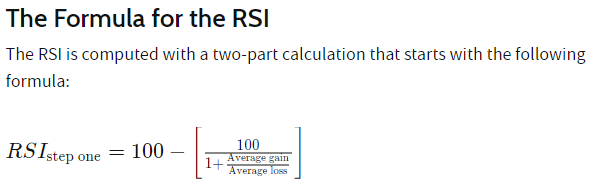

Calculating the RSI is a little challenging and computing these features is not the goal of this notebook, so I will once again modify an existing function created by someone else and posted on github, the credit is as follows: <br>

***************************************************************************************
*    Title: Pandas-Technical-Indicators
*    Author: egor-bogomolov
*    Date: March 28, 2018
*    Code version: 1.0
*    Availability: https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py
***************************************************************************************

In [14]:
def RSI(df, n = 14):
    """Calculate Relative Strength Index(RSI) for given data.
    
    df: dataframe containing the High and Low price columns
    n: the amount of daya to aggregate over, but the traditional number for RSI is 14, so we set that as default 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
        DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.DataFrame(UpI)
    DoI = pd.DataFrame(DoI)
    PosDI = pd.DataFrame(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.DataFrame(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.DataFrame(PosDI / (PosDI + NegDI))
    
    return RSI

In [15]:
RSI_feature = pd.concat([bitcoin_df['High'], bitcoin_df['Low']], axis = 1)
RSI_feature['RSI'] = RSI(RSI_feature)
RSI_feature.head(20)

,High,Low,RSI
0,93.608000,93.503000,NaN
1,93.612000,93.380000,NaN
2,93.796000,93.680000,NaN
3,93.980000,93.980000,NaN
4,94.159000,94.159000,NaN
5,94.338000,94.338000,NaN
6,94.517000,94.517000,NaN
7,94.696000,94.696000,NaN
8,94.621333,94.621333,NaN
9,94.546667,94.546667,NaN


Once again I will have to impute 0's for the NaN's, which will be the first 13 entries as they can't be defined with the 14 day moving average requirement.

In [16]:
RSI_feature['RSI'].fillna(0, inplace = True)
RSI_feature.isna().sum()

High    0
Low     0
RSI     0
dtype: int64

In [17]:
bitcoin_features_df = pd.concat([bitcoin_features_df, RSI_feature['RSI']], axis = 1)
bitcoin_features_df

,OBV,EMA_7,EMA_14,EMA_21,EMA_28,EMA_50,EMA_100,EMA_250,RSI
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-172.309017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,86.527408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.745799,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.759350,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
916712,1.340725,46719.330248,46746.749042,46760.634241,46761.261236,46728.224930,46720.803524,46946.698077,0.426702
916713,6.393124,46740.497686,46754.382503,46764.576582,46764.208737,46731.196501,46722.450979,46945.561041,0.568862
916714,2.147162,46760.623265,46763.264836,46769.705984,46768.125376,46734.718207,46724.402445,46944.568523,0.624253
916715,-1.076775,46747.717448,46756.029524,46764.187258,46764.047764,46733.709650,46724.097446,46942.691483,0.424825


## Fear and Greed Index <a class = "achor" id = "fear_greed"></a>

The Fear and Greed Index is a unique indicator created for cryptocurrencies. It is an accumulation of several metrics. <br>
The value ranges from 0 to 100 where 0 is considered __Extreme Fear__ and 100 being __Extreme Greed__. Each of the following metrics contributes in some way to this metric creation.<br>
- Volatility (25%): Measuring the current volume and max. downdraws of bitcoin compared with the corresponding average values of the last 30 and 90 days. Unusual rise in volatility is a sign of a __fearful__ market.
- Market Momentum/Volume (25%): Current volume and market momentum (in comparison to the avergae last 30/90 days) and put those two values together. High buying volumes on a daily basis in a positive market indicates __greed__.
- Social Media (15%): An analysis of twitter hashtags for each coin looking at how fast and many interactions they recieve in a certain time frame. An unsusal high interaction rate results in growing public interest and is an indicator of __greed__.
- Surveys (15%) (Paused early 2022): Around 2000 - 3000 votes on each poll asking investors about their market sentiment.
- Dominance (10%): Refers to what percentage of the total market cap of the cryprocurrency industry this coin prepresents. When Bitcoin dominance shrinks, it is an indicator of __greed__, when it rises it is an indicator of __fear__.
- Trends (10%): Collections of several search queries on google trends, especially on the trend of search volume. Also the looking at the "related search queries" offered by google showing new search terms that have gained traction. 

One problem with this indicator is that the data only starts on February 1st, 2018 when my data starts at the beginning of 2014. I will only be able to use this indicator for narrower time modelling, but this includes the most recent "bull run" that began in later 2020. I will later conduct a comparison of a model where I include this metric and one where I dont.

### Download Data <a class = "anchor" id = "download_greed"></a>

To get the data I will have to use the Alternative.me's API which is a RESTful API. The way to request data is in the form of a URL where I set parts of the URL to specific parameters I wish to include. In this case I set the `limit` to 0, meaning I want all of the entries. `format` to JSON to get a JSON response and `date_format` to kr for Korea so I get the timestamp in the format of (YYYY-MM-DD).<br><br>

Once I have the data I can save it as a dataframe.

In [18]:
response = requests.get("https://api.alternative.me/fng/?limit=0&format=json&date_format=kr")

In [19]:
data = response.json()

fear_greed_df = pd.DataFrame(data['data'])

fear_greed_df['timestamp'] = pd.to_datetime(fear_greed_df['timestamp'])

In [20]:
fear_greed_df.head()

,value,value_classification,timestamp,time_until_update
0,52,Neutral,2022-04-04,-1648960772
1,48,Neutral,2022-04-03,NaN
2,52,Neutral,2022-04-02,NaN
3,50,Neutral,2022-04-01,NaN
4,52,Neutral,2022-03-31,NaN


In [21]:
fear_greed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1521 entries, 0 to 1520
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   value                 1521 non-null   object        
 1   value_classification  1521 non-null   object        
 2   timestamp             1521 non-null   datetime64[ns]
 3   time_until_update     1 non-null      object        
dtypes: datetime64[ns](1), object(3)
memory usage: 47.7+ KB


There are only around 1500 days of data (increases every day since its taking recent data as well), meaning the data doesn't reach as far back as our historical price data. I will have to cut this feature out whenever modelling with data that is outside of this time range, but models will be run with it included to see its effect.

In [22]:
fear_greed_df.tail(3)

,value,value_classification,timestamp,time_until_update
1518,40,Fear,2018-02-03,NaN
1519,15,Extreme Fear,2018-02-02,NaN
1520,30,Fear,2018-02-01,NaN


The data for the Fear and Greed Index starts on February 1st, 2018.

The next step is to resample this data to the time interval the original data is in. I stored this value earlier in `time_interval`. I will also drop all columns except for `Date` and `value`.

In [23]:
temp_df = fear_greed_df.set_index("timestamp").resample(time_interval).ffill().reset_index().rename(
    {"timestamp": "Date"}, axis=1)
temp_df.drop(columns = ['value_classification', 'time_until_update'], inplace = True)

In [24]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438625 entries, 0 to 438624
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    438625 non-null  datetime64[ns]
 1   value   438625 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 6.7+ MB


Now I want to add the `value` column to the `bitcoin_features_df`, but it doesnt have a date column I can use to match on. So I will also add a date column to that dataframe.

In [25]:
bitcoin_features_df['Date'] = bitcoin_df['Date']
bitcoin_features_df['Date'] = pd.to_datetime(bitcoin_features_df['Date'])
bitcoin_features_df.head()

,OBV,EMA_7,EMA_14,EMA_21,EMA_28,EMA_50,EMA_100,EMA_250,RSI,Date
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013-04-15 04:00:00
1,-172.309017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013-04-15 04:05:00
2,86.527408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013-04-15 04:10:00
3,0.745799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013-04-15 04:15:00
4,0.759350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013-04-15 04:20:00


In [26]:
bitcoin_features_df = pd.merge(temp_df, bitcoin_features_df, left_on='Date', right_on='Date', how = 'right')
bitcoin_features_df.rename(columns = {'value': 'fg_index'}, inplace = True)
bitcoin_features_df

,Date,fg_index,OBV,EMA_7,EMA_14,EMA_21,EMA_28,EMA_50,EMA_100,EMA_250,RSI
0,2013-04-15 04:00:00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2013-04-15 04:05:00,NaN,-172.309017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2013-04-15 04:10:00,NaN,86.527408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2013-04-15 04:15:00,NaN,0.745799,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2013-04-15 04:20:00,NaN,0.759350,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
916712,2022-01-01 04:40:00,21,1.340725,46719.330248,46746.749042,46760.634241,46761.261236,46728.224930,46720.803524,46946.698077,0.426702
916713,2022-01-01 04:45:00,21,6.393124,46740.497686,46754.382503,46764.576582,46764.208737,46731.196501,46722.450979,46945.561041,0.568862
916714,2022-01-01 04:50:00,21,2.147162,46760.623265,46763.264836,46769.705984,46768.125376,46734.718207,46724.402445,46944.568523,0.624253
916715,2022-01-01 04:55:00,21,-1.076775,46747.717448,46756.029524,46764.187258,46764.047764,46733.709650,46724.097446,46942.691483,0.424825


I have successfully added the fear and greed index to the dataset. Lets replace the NaN values with 0, and move on to adding new features.

In [27]:
bitcoin_features_df['fg_index'].fillna(value = 0, inplace = True)
bitcoin_features_df.isna().sum()

Date        0
fg_index    0
OBV         0
EMA_7       0
EMA_14      0
EMA_21      0
EMA_28      0
EMA_50      0
EMA_100     0
EMA_250     0
RSI         0
dtype: int64

## Puell Multiple <a class = "anchor" id = "puell"></a>

This metric looks at the supply side of Bitcoin's economy - bitcoin miners and their revenue.
It explores market cycles from a mining revenue perspective. Bitcoin miners are sometimes referred to as compulsory sellers due to their need to cover fixed costs of mining hardware in a market where price is extremely volatile. The revenue they generate can therefore influence price over time.<br>

The Puell Multiple is calculated by dividing the daily issuance value of bitcoins (in USD) by the 365-day moving average of daily issuance value.<br>

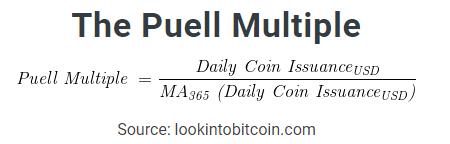

A low Puell multiple suggests that miners are not earning very much money, so they are incentivised to hold their coins until the price increases to cover their realtively stable costs. A high Puell multiple suggests that miners are selling their newly minted coins to cover their cost of operations and take profit.

Since this calculation depends on the daily issuance of bitcoin, I need to aquire those numbers. Traditionally, downloading the entire 456GB Bitcoin blockchain could accomplish this task, but since the minting schedule follows rules, I can safely estimate those numbers and save a lot of time and resources. 

Since this is a metric that only updates once per day (looks at daily issuance, not hourly or by minute), I will resample the dataframe dates to 1-day intervals, compute the Puell Multiple, and then resample again back to `time_interval` intervals. At that point I can add it to the `bitcoin_features_df`. I will also convert the `date` column to the number of days since the first block issuance on the Bitcoin blockchain. This will help to determine what block reward cycle we are currenly in. Every 1,458.33 days the rewards for each block are halved, affecting the daily issuance.

In [28]:
puell_df = pd.DataFrame()
puell_df['Date'] = bitcoin_df['Date']
puell_df['Date'] = pd.to_datetime(puell_df['Date'])

puell_df['Value'] = bitcoin_df['Open']
puell_df.set_index('Date', inplace = True)
puell_df = puell_df.resample('D').mean()
temp_date = puell_df.index # save the resampled date format so we can resample back again later
puell_df.sort_values(by = "Date", inplace = True) # have the dates start with the earliest first
puell_df.reset_index(inplace = True, drop = True)
puell_df.reset_index(inplace = True)


#While the first block was mined on January 3rd, 2009, proper mining didnt start until 6 days later on January 9th.
# We will have to add the numbers of days since January 9th, 2009 and the first date of our dataset (April 15th, 2013) to 
# our index column to properly reflect the days since mining began.
# The number of days between those dates are 1,557, plus one to offset for the index starting at 0

puell_df['index'] += 1557
puell_df

,index,Value
0,1557,93.343552
1,1558,66.376708
2,1559,82.747298
3,1560,94.566261
4,1561,118.794566
...,...,...
3179,4736,48878.768493
3180,4737,47597.815106
3181,4738,47109.523403
3182,4739,47297.407534


In [29]:
# Bitcoin's algorithm targets 10 minutes as the average block time, there are 1440 minutes in a day, so 144 blocks per day.
# At the beginning the daily issuance would have been 7200 btc as the block rewards were 50 BTC at the time.
# There are 1458.3 days between halvings, so we take the days since the first block, divide it by days in a halving cycle, and then 
# take that number to the power of 2 and divide by 7200 to find that days BTC issuance.
puell_df['BTC_issuance'] = 7200 / 2**(np.floor(puell_df['index'] / 1458 )) # we round down to get the halving cycle as an integer
puell_df['USD_issuance'] = puell_df['BTC_issuance'] * puell_df['Value']
puell_df['MA_USD_issuance'] = puell_df['USD_issuance'].rolling(window = 365).mean() # calculate 365-day moving average of btc issued in USD value
puell_df['MA_USD_issuance'].fillna(0, inplace = True) # fill in NaN values that exists for first 365 days
puell_df['puell'] = puell_df['USD_issuance'] / puell_df['MA_USD_issuance']
puell_df.replace([np.inf, -np.inf], 0, inplace = True) # replace the inf numbers for the first 365 days with 0
puell_df

,index,Value,BTC_issuance,USD_issuance,MA_USD_issuance,puell
0,1557,93.343552,3600.0,3.360368e+05,0.000000e+00,0.000000
1,1558,66.376708,3600.0,2.389561e+05,0.000000e+00,0.000000
2,1559,82.747298,3600.0,2.978903e+05,0.000000e+00,0.000000
3,1560,94.566261,3600.0,3.404385e+05,0.000000e+00,0.000000
4,1561,118.794566,3600.0,4.276604e+05,0.000000e+00,0.000000
...,...,...,...,...,...,...
3179,4736,48878.768493,900.0,4.399089e+07,4.263478e+07,1.031808
3180,4737,47597.815106,900.0,4.283803e+07,4.262065e+07,1.005100
3181,4738,47109.523403,900.0,4.239857e+07,4.259801e+07,0.995318
3182,4739,47297.407534,900.0,4.256767e+07,4.264355e+07,0.998221


Now I can reshape our data back to our `time_interval` intervals, and use forwardfill to impute the new in-between values. 

In [30]:
puell_df['index'] = temp_date
puell_5m_df = puell_df.set_index("index").resample(time_interval).bfill().reset_index().rename(
    {"index": "Date"}, axis=1)
puell_5m_df.head()
puell_5m_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916705 entries, 0 to 916704
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Date             916705 non-null  datetime64[ns]
 1   Value            916705 non-null  float64       
 2   BTC_issuance     916705 non-null  float64       
 3   USD_issuance     916705 non-null  float64       
 4   MA_USD_issuance  916705 non-null  float64       
 5   puell            916705 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 42.0 MB


I can see that the `puell` variable has 12 less entries than the other bitcoin features, which is a byproduct of resampling to a 1 day time interval, and then back down to 5 minutes. Some entries were lost at the end, specifically the last 5 hours, band some were gained at the beginning, the first 4 hours, which explains the 12 less entries. I will merge the `bitcoin_features_df` with the `puell_5m_df` on their date column, which will cut off the first 4 hours I dont want, and will create NaN's for missing 5 hours at the end. <br><br> At the very end I will be cutting up the dataset, so a few values at the end don't matter, so I can safely cut them out later.

In [31]:
puell_5m_df.tail()

,Date,Value,BTC_issuance,USD_issuance,MA_USD_issuance,puell
916700,2021-12-31 23:40:00,46722.413163,900.0,4.205017e+07,4.268668e+07,0.985089
916701,2021-12-31 23:45:00,46722.413163,900.0,4.205017e+07,4.268668e+07,0.985089
916702,2021-12-31 23:50:00,46722.413163,900.0,4.205017e+07,4.268668e+07,0.985089
916703,2021-12-31 23:55:00,46722.413163,900.0,4.205017e+07,4.268668e+07,0.985089
916704,2022-01-01 00:00:00,46722.413163,900.0,4.205017e+07,4.268668e+07,0.985089


In [32]:
bitcoin_features_df.head()

,Date,fg_index,OBV,EMA_7,EMA_14,EMA_21,EMA_28,EMA_50,EMA_100,EMA_250,RSI
0,2013-04-15 04:00:00,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-04-15 04:05:00,0,-172.309017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-04-15 04:10:00,0,86.527408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-04-15 04:15:00,0,0.745799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-04-15 04:20:00,0,0.759350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
bitcoin_features_df = pd.merge(puell_5m_df, bitcoin_features_df, left_on='Date', right_on='Date', how = 'right')

In [34]:
bitcoin_features_df.head(50)

,Date,Value,BTC_issuance,USD_issuance,MA_USD_issuance,puell,fg_index,OBV,EMA_7,EMA_14,EMA_21,EMA_28,EMA_50,EMA_100,EMA_250,RSI
0,2013-04-15 04:00:00,66.376708,3600.0,238956.15,0.0,0.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1,2013-04-15 04:05:00,66.376708,3600.0,238956.15,0.0,0.0,0,-172.309017,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2,2013-04-15 04:10:00,66.376708,3600.0,238956.15,0.0,0.0,0,86.527408,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
3,2013-04-15 04:15:00,66.376708,3600.0,238956.15,0.0,0.0,0,0.745799,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
4,2013-04-15 04:20:00,66.376708,3600.0,238956.15,0.0,0.0,0,0.759350,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
5,2013-04-15 04:25:00,66.376708,3600.0,238956.15,0.0,0.0,0,0.772900,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
6,2013-04-15 04:30:00,66.376708,3600.0,238956.15,0.0,0.0,0,0.786450,94.161838,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
7,2013-04-15 04:35:00,66.376708,3600.0,238956.15,0.0,0.0,0,0.800000,94.310235,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
8,2013-04-15 04:40:00,66.376708,3600.0,238956.15,0.0,0.0,0,-0.567300,94.394323,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
9,2013-04-15 04:45:00,66.376708,3600.0,238956.15,0.0,0.0,0,-0.334600,94.434682,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000


I will drop all columns except for `puell`, as it's the only data needed. Quickly rename the puell column and inspect the data frame.

In [35]:
bitcoin_features_df.drop(columns = ['BTC_issuance', 'USD_issuance', 'MA_USD_issuance', 'Value'], inplace = True)

In [36]:
bitcoin_features_df.rename(columns = {'puell': 'Puell'}, inplace = True)

In [37]:
bitcoin_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 916717 entries, 0 to 916716
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Date      916717 non-null  datetime64[ns]
 1   Puell     916657 non-null  float64       
 2   fg_index  916717 non-null  object        
 3   OBV       916717 non-null  float64       
 4   EMA_7     916717 non-null  float64       
 5   EMA_14    916717 non-null  float64       
 6   EMA_21    916717 non-null  float64       
 7   EMA_28    916717 non-null  float64       
 8   EMA_50    916717 non-null  float64       
 9   EMA_100   916717 non-null  float64       
 10  EMA_250   916717 non-null  float64       
 11  RSI       916717 non-null  float64       
dtypes: datetime64[ns](1), float64(10), object(1)
memory usage: 90.9+ MB


There are a total of 60 NULL values, which makes sense since we are missing 5 hours of Puell variable data at the end, and 4 hours at the front due to resampling to our 5 minute time interval. I won't address the NULL values here since I will be cutting the dataset at the end anyway to account for some overage calculations, as well as initial missing values from moving average calculations.

## Stock-to-Flow Model (S2F) <a class = "anchor" id = "s2f"></a>

Next up is one of the more interesting models that have sprung up around Bitcoin, it is also one of the most well-known ones. This model was created by an author under the pseudonym PlanB and is an investment model that measures an asset’s current stock against the rate of production or the total amount mined over the course of a year. Stock-to-flow is used to compare the relative abundance or scarcity of a particular resource.

Though traditionally used as a way to compare various established resources, stock-to-flow has been adapted as a way to valuate Bitcoin, the first scarce digital resource that’s believed to be a store of value.<br><br>

Stock to Flow is calculated as stock/flow, where:
    * stock: Current circulating supply of Bitcoin
    * flow: Yearly Bitcoin issuance based on todays daily issuance
<br>

The author PlanB suggested the price model: Model Price(USD) = 0.4 * S2F^3

I will write a function that calculates the current stock-to-flow ratio and finds the model price. It then stores this price in the corresponding row by date.

Some key information we need is the circulating supply for our first time interval, April 15th, 2013. A quick google search reveals that number is roughly 11,050,000 BTC. The real number at the minute of our starting time interval is slightly different, but getting the fully accurate number would require then entire 456GB Bitcoin blockchain. This number is within a few thousand Bitcoin, meaning our estimate is close enough to reality.


In [38]:
def s2f_model ():
    df = pd.DataFrame()
    df['stock'] = 0
    df['flow'] = 0
    df.loc[0,'stock'] = 11_050_000
    i = 1
    
    for i in range(1, puell_df.shape[0]):
        j = i - 1
            
        df.loc[i,'stock'] = df.loc[j, 'stock'] + puell_df.loc[i, 'BTC_issuance']
        df.loc[i, 'flow'] = puell_df.loc[i, 'BTC_issuance'] * 365.25
    
    df['s2f_ratio'] = df['stock']/df['flow']
    
    df['S2F'] = 0.4 * (df['s2f_ratio']**3)
    
        
    return df

In [39]:
s2f_df = pd.DataFrame()
s2f_df = s2f_model()

The next step here is to resample the data into the 5 minute intervals as the current data is only for daily time intervals. This is because I estimated the BTC issuance earlier for the Puell Multiple on a daily time frame, as once again the Bitcoin Blockchain itself is required to get more accurate data.<br><br>
We also have to add a `date` column so that we can properly resample, we will simply use the date from the `puell_df` data frame as I know the days match up, since we used that dataframe to create this one.

In [40]:
s2f_df['S2F'].fillna(0, inplace = True)
s2f_df['Date'] = puell_df['index']
s2f_df.set_index('Date', inplace = True)

In [41]:
s2f_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3184 entries, 2013-04-15 to 2022-01-01
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   stock      3184 non-null   float64
 1   flow       3183 non-null   float64
 2   s2f_ratio  3183 non-null   float64
 3   S2F        3184 non-null   float64
dtypes: float64(4)
memory usage: 124.4 KB


I will also set the first value to the second rows value to avoid a 0 value that would be incorrect, same thing with the `stock` column. <br><br> The `stock` column refers to the circulating supply of bitcoin, and is a great metric for EDA and maybe modelling.

In [42]:
s2f_df = s2f_df.resample('5T').bfill()
s2f_df.loc['2013-04-15 00:00:00', 'S2F'] = s2f_df.loc['2013-04-15 00:05:00', 'S2F']
s2f_df.loc['2013-04-15 00:00:00', 'stock'] = s2f_df.loc['2013-04-15 00:05:00', 'stock']
s2f_df.head()

,stock,flow,s2f_ratio,S2F
Date,,,,
2013-04-15 00:00:00,11053600.0,NaN,NaN,237.625503
2013-04-15 00:05:00,11053600.0,1314900.0,8.406419,237.625503
2013-04-15 00:10:00,11053600.0,1314900.0,8.406419,237.625503
2013-04-15 00:15:00,11053600.0,1314900.0,8.406419,237.625503
2013-04-15 00:20:00,11053600.0,1314900.0,8.406419,237.625503


I will also drop `flow` and `s2f_ratio` columns, as they are simply intermediary results from the calculation.

In [43]:
s2f_df.drop(columns = ['flow', 's2f_ratio'], inplace = True)

In [44]:
s2f_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 916705 entries, 2013-04-15 00:00:00 to 2022-01-01 00:00:00
Freq: 5T
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   stock   916705 non-null  float64
 1   S2F     916705 non-null  float64
dtypes: float64(2)
memory usage: 53.2 MB


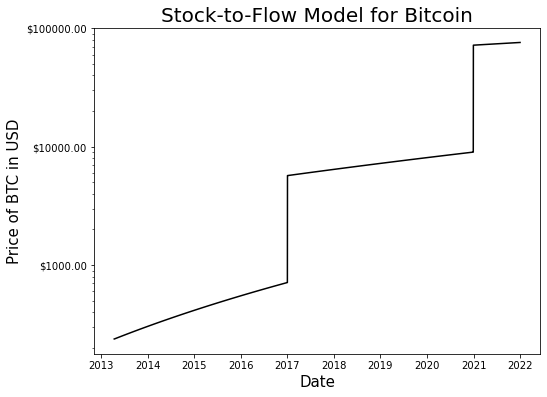

In [45]:
fig, ax = plt.subplots(figsize = (8,6))
plt.plot(s2f_df.index, s2f_df['S2F'], color = 'black')
plt.yscale('log')
plt.title("Stock-to-Flow Model for Bitcoin", size = 20)
plt.xlabel('Date', size = 15)
ax.yaxis.set_major_formatter('${x:1.2f}')
ax.yaxis.set_tick_params(which='major', labelcolor='black',
                         labelleft=True, labelright=False)
plt.ylabel('Price of BTC in USD', size = 15)

plt.show()

This is a great start, but the price of Bitcoin would never have these sharp rises, so creating a 463 day moving average of the stock to flow model is [considered a better model](https://stats.buybitcoinworldwide.com/stock-to-flow/) line. The `window` needs to be set to the equivalent time span of 463 days. In this case I am using 5 minute intervals so the equation is 1 time interval (5 minutes) x 12 (1hour) x 24 hours x 463 days = 133,344 5-minute intervals in one year.

In [46]:
s2f_df['S2F_463MA'] = s2f_df['S2F'].rolling(window=133344).mean()

In [47]:
s2f_df.fillna(0)

,stock,S2F,S2F_463MA
Date,,,
2013-04-15 00:00:00,11053600.0,237.625503,0.000000
2013-04-15 00:05:00,11053600.0,237.625503,0.000000
2013-04-15 00:10:00,11053600.0,237.625503,0.000000
2013-04-15 00:15:00,11053600.0,237.625503,0.000000
2013-04-15 00:20:00,11053600.0,237.625503,0.000000
...,...,...,...
2021-12-31 23:40:00,18893500.0,75944.974922,60481.476334
2021-12-31 23:45:00,18893500.0,75944.974922,60481.980221
2021-12-31 23:50:00,18893500.0,75944.974922,60482.484107


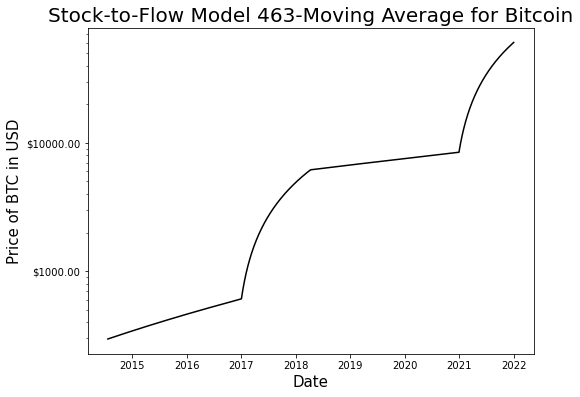

In [48]:
fig, ax = plt.subplots(figsize = (8,6))
plt.plot(s2f_df.index, s2f_df['S2F_463MA'], color = 'black')
plt.yscale('log')
plt.title("Stock-to-Flow Model 463-Moving Average for Bitcoin", size = 20)
plt.xlabel('Date', size = 15)
ax.yaxis.set_major_formatter('${x:1.2f}')
ax.yaxis.set_tick_params(which='major', labelcolor='black',
                         labelleft=True, labelright=False)
plt.ylabel('Price of BTC in USD', size = 15)

plt.show()

This is a much more realistic line, even though the price of Bitcoin isnt expected to be exactly predicted by the Stock-to-Flow model, rather its a measure of if the price is over or undervalued based on its scarcity. <br><br>

I can now add this data to the `bitcoin_features_df` by mergeing on their date columns.

In [49]:
s2f_df.drop(columns = 'S2F', inplace = True)

In [50]:
bitcoin_features_df = pd.merge(s2f_df, bitcoin_features_df, left_on='Date', right_on='Date', how = 'right')

In [51]:
bitcoin_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 916717 entries, 0 to 916716
Data columns (total 14 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       916717 non-null  datetime64[ns]
 1   stock      916657 non-null  float64       
 2   S2F_463MA  783362 non-null  float64       
 3   Puell      916657 non-null  float64       
 4   fg_index   916717 non-null  object        
 5   OBV        916717 non-null  float64       
 6   EMA_7      916717 non-null  float64       
 7   EMA_14     916717 non-null  float64       
 8   EMA_21     916717 non-null  float64       
 9   EMA_28     916717 non-null  float64       
 10  EMA_50     916717 non-null  float64       
 11  EMA_100    916717 non-null  float64       
 12  EMA_250    916717 non-null  float64       
 13  RSI        916717 non-null  float64       
dtypes: datetime64[ns](1), float64(12), object(1)
memory usage: 104.9+ MB


There are 133,344 NULL values in S2F_463MA as that is how many 5-minute time intervals are in a year, meaning they can't have a value for the 463 day moving average it is calculating. There are also 60 NULL entries for `stock`, but that is to be expected as the same issue occured with resampling as did with the `puell` feature. Again, this wont be an issue as we will cut our dataset at the end to avoid a few hours of missing data on either end.

## Adding Features to Original Data <a class = "anchor" id = "adding"></a>

Before I add the features back to the original dataset, lets convert the `fg_index` to a float64 like the rest of the features. I can also drop the `Date` column now as it already exists in the original data.

In [52]:
bitcoin_features_df['fg_index'] = bitcoin_features_df['fg_index'].astype('float64')
bitcoin_features_df.drop(columns = 'Date', inplace = True)
bitcoin_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 916717 entries, 0 to 916716
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   stock      916657 non-null  float64
 1   S2F_463MA  783362 non-null  float64
 2   Puell      916657 non-null  float64
 3   fg_index   916717 non-null  float64
 4   OBV        916717 non-null  float64
 5   EMA_7      916717 non-null  float64
 6   EMA_14     916717 non-null  float64
 7   EMA_21     916717 non-null  float64
 8   EMA_28     916717 non-null  float64
 9   EMA_50     916717 non-null  float64
 10  EMA_100    916717 non-null  float64
 11  EMA_250    916717 non-null  float64
 12  RSI        916717 non-null  float64
dtypes: float64(13)
memory usage: 97.9 MB


Let's add the features back to the original data.

In [53]:
bitcoin_df = pd.concat([bitcoin_df, bitcoin_features_df], axis = 1)
bitcoin_df.head(3)

,Date,Open,Close,High,Low,Volume,stock,S2F_463MA,Puell,fg_index,OBV,EMA_7,EMA_14,EMA_21,EMA_28,EMA_50,EMA_100,EMA_250,RSI
0,2013-04-15 04:00:00,93.6080,93.5030,93.608,93.503,49.168679,11053600.0,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-04-15 04:05:00,93.5050,93.4970,93.612,93.380,172.309017,11053600.0,NaN,0.0,0.0,-172.309017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-04-15 04:10:00,93.7425,93.7385,93.796,93.680,86.527408,11053600.0,NaN,0.0,0.0,86.527408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916717 entries, 0 to 916716
Data columns (total 19 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       916717 non-null  datetime64[ns]
 1   Open       916717 non-null  float64       
 2   Close      916717 non-null  float64       
 3   High       916717 non-null  float64       
 4   Low        916717 non-null  float64       
 5   Volume     916717 non-null  float64       
 6   stock      916657 non-null  float64       
 7   S2F_463MA  783362 non-null  float64       
 8   Puell      916657 non-null  float64       
 9   fg_index   916717 non-null  float64       
 10  OBV        916717 non-null  float64       
 11  EMA_7      916717 non-null  float64       
 12  EMA_14     916717 non-null  float64       
 13  EMA_21     916717 non-null  float64       
 14  EMA_28     916717 non-null  float64       
 15  EMA_50     916717 non-null  float64       
 16  EMA_100    916717 no

Let's also convert the `Date` column to the datetime dtype.

In [55]:
bitcoin_df['Date'] = pd.to_datetime(bitcoin_df['Date'])
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916717 entries, 0 to 916716
Data columns (total 19 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       916717 non-null  datetime64[ns]
 1   Open       916717 non-null  float64       
 2   Close      916717 non-null  float64       
 3   High       916717 non-null  float64       
 4   Low        916717 non-null  float64       
 5   Volume     916717 non-null  float64       
 6   stock      916657 non-null  float64       
 7   S2F_463MA  783362 non-null  float64       
 8   Puell      916657 non-null  float64       
 9   fg_index   916717 non-null  float64       
 10  OBV        916717 non-null  float64       
 11  EMA_7      916717 non-null  float64       
 12  EMA_14     916717 non-null  float64       
 13  EMA_21     916717 non-null  float64       
 14  EMA_28     916717 non-null  float64       
 15  EMA_50     916717 non-null  float64       
 16  EMA_100    916717 no

## Trimming Data <a class = "anchor" id = "trimming"></a>

Finally I can go ahead and trim my dataset to the ranges I initially stated, July 22nd, 2014 to January 1st, 2022.

In [56]:
#this cell may take a minute to run
bitcoin_final_df = pd.DataFrame()
bitcoin_final_df = bitcoin_df[(bitcoin_df['Date'] > '2014-07-22 00:00:00') & (bitcoin_df['Date'] <= '2022-01-01 00:00:00')] 

In [57]:
bitcoin_final_df.head(3)

,Date,Open,Close,High,Low,Volume,stock,S2F_463MA,Puell,fg_index,OBV,EMA_7,EMA_14,EMA_21,EMA_28,EMA_50,EMA_100,EMA_250,RSI
133297,2014-07-22 00:05:00,620.00,620.01,620.01,620.00,0.344121,12720400.0,296.847105,1.274937,0.0,0.000000,619.818544,619.634917,619.515163,619.430556,619.288653,619.249372,619.741131,0.675838
133298,2014-07-22 00:10:00,620.01,619.50,620.01,619.50,0.772000,12720400.0,296.848038,1.274937,0.0,-0.772000,619.738908,619.616928,619.513784,619.435346,619.296941,619.254335,619.739210,0.522166
133299,2014-07-22 00:15:00,620.01,619.91,620.25,619.67,1.581333,12720400.0,296.848972,1.274937,0.0,1.581333,619.781681,619.656004,619.549804,619.468080,619.320983,619.267319,619.740571,0.575611


In [58]:
bitcoin_final_df.tail(3)

,Date,Open,Close,High,Low,Volume,stock,S2F_463MA,Puell,fg_index,OBV,EMA_7,EMA_14,EMA_21,EMA_28,EMA_50,EMA_100,EMA_250,RSI
916654,2021-12-31 23:50:00,46394.000000,46280.0,46394.000000,46280.0,6.882113,18893500.0,60482.484107,0.985089,28.0,-6.882113,46386.813063,46389.818102,46373.723230,46360.876083,46399.156478,46659.048053,47072.526755,0.457956
916655,2021-12-31 23:55:00,46279.999208,46218.0,46279.999208,46150.0,20.508200,18893500.0,60482.987993,0.985089,28.0,-20.508200,46344.609797,46366.909022,46359.566573,46351.022560,46392.052303,46650.314428,47065.717777,0.297859
916656,2022-01-01 00:00:00,46209.000000,46311.0,46386.000000,46203.0,15.039855,18893500.0,60483.491879,0.985089,21.0,15.039855,46336.207348,46359.454485,46355.151430,46348.262383,46388.873781,46643.595331,47059.704090,0.471640


All of our features not have proper values, except for `fg_index`, which is to be expected as the data only begins on February 1st, 2018. I will also set the Date column as the index.

In [59]:
bitcoin_final_df.set_index('Date', inplace = True)
bitcoin_final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 783360 entries, 2014-07-22 00:05:00 to 2022-01-01 00:00:00
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Open       783360 non-null  float64
 1   Close      783360 non-null  float64
 2   High       783360 non-null  float64
 3   Low        783360 non-null  float64
 4   Volume     783360 non-null  float64
 5   stock      783360 non-null  float64
 6   S2F_463MA  783360 non-null  float64
 7   Puell      783360 non-null  float64
 8   fg_index   783360 non-null  float64
 9   OBV        783360 non-null  float64
 10  EMA_7      783360 non-null  float64
 11  EMA_14     783360 non-null  float64
 12  EMA_21     783360 non-null  float64
 13  EMA_28     783360 non-null  float64
 14  EMA_50     783360 non-null  float64
 15  EMA_100    783360 non-null  float64
 16  EMA_250    783360 non-null  float64
 17  RSI        783360 non-null  float64
dtypes: float64(18)
memory usage: 1

In [60]:
bitcoin_final_df.isna().sum()

Open         0
Close        0
High         0
Low          0
Volume       0
stock        0
S2F_463MA    0
Puell        0
fg_index     0
OBV          0
EMA_7        0
EMA_14       0
EMA_21       0
EMA_28       0
EMA_50       0
EMA_100      0
EMA_250      0
RSI          0
dtype: int64

All columns have the same number of non-NULL rows, and none have any NULL values as well. The Data is ready to be saved for EDA and modelling.

## Data Dictionary <a class = "anchor" id = "dict"></a>

- `Date`: Date of the observation (DateTime)
- `Open`: Opening Price of Observation (numeric)
- `Close`: Closing Price of Observation (numeric)
- `High`: Highest Price during Observation (numeric)
- `Low`: Lowest Price during Observation (numeric)
- `Volume`: Volume of Bitcoin traded during Observation (numeric)
- `stock`: Circulating Supply of Bitcoin during Observation (numeric)
- `S2F_463MA`: Stock-to-Flow Model value during Observation (numeric)
- `Puell`: Puell Multiple during Observation (numeric)
- `fg_index`: Fear and Greed Index value during Observation (numeric)
- `OBV`: On-balance Volume during Observation (numeric)
- `EMA_7`: Exponential Moving Average of 7 time intervals during Observation (numeric)
- `EMA_14`:: Exponential Moving Average of 14 time intervals during Observation (numeric)
- `EMA_21`: Exponential Moving Average of 21 time intervals during Observation (numeric)
- `EMA_28`: Exponential Moving Average of 28 time intervals during Observation (numeric)
- `EMA_50`: Exponential Moving Average of 50 time intervals during Observation (numeric)
- `EMA_100`: Exponential Moving Average of 100 time intervals during Observation (numeric)
- `EMA_250`: Exponential Moving Average of 250 time intervals during Observation (numeric)

## Saving Data <a class = "anchor" id = "saving"></a>

I now have a dataset ready for modelling. However, the process will first continue the Exploratory Data Analysis workbook where I take a look at key dates and metrics in the Cryptocurrency Markets using the newly aquired dataset. Let's also export this dataframe to a CSV file.

In [61]:
bitcoin_final_df.to_csv(f"./data/{pair} {time_interval} Historical_Data_Modelling.csv")